# Max-k-cut

In [1]:
%load_ext autoreload
%autoreload 2

from qiskit import *
import numpy as np
import pylab as pl
import networkx as nx
from qiskit.visualization import *
from qiskit.providers.aer.noise import NoiseModel
from qaoa import *
from pylab import cm

from matplotlib import rc,patches
from scipy import optimize as opt

# Parameters when sampling the entire parameter space
SAMPLING_E_ATOL = np.inf#1e-1
SAMPLING_E_RTOL = np.inf#1e-1
SAMPLING_DELTA_V_RTOL = 1e-1
MIN_SAMPLES = 8192
MAX_SAMPLES = 8192
SAMPLING_CONF_IDX = 2
LANDSCAPE_RESOLUTION = 16

BRUTE_FORCE=False


# Other parameters
WEIGHT_DECIMALS = 0
CIRCUIT_VERSION = 1
CIRCUIT_DEPTH = 1
K_CUTS = 4

font = {'size' : 16}
rc('font', **font);
rc('text', usetex=True)

100%
Max cost: 1


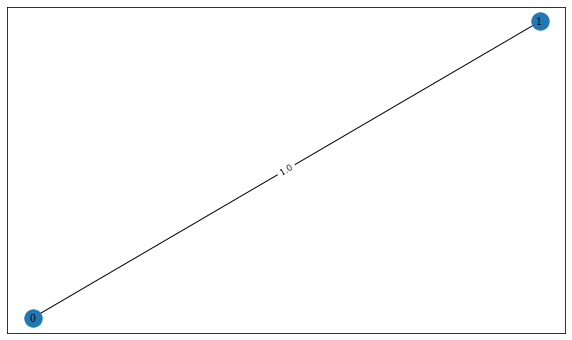

In [2]:
#V = np.arange(0,5,1)
#E =[(0,1),(1,2),(2,0),(2,3),(1,3),(2,4),(3,4)]
#V = np.arange(0,5,1)
#E =[(0,1),(1,2),(2,3),(3,0),(0,4),(1,4)]
V = np.arange(0,2,1)
E =[(0,1)]
G = nx.Graph()
G.add_nodes_from(V)
G.add_edges_from(E)
addWeights_MaxCut(G,decimals=WEIGHT_DECIMALS)

pl.figure(figsize=(10,6))
pos = nx.spring_layout(G)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx(G,pos)
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

V1 = np.arange(0,)
costs=costsHist_MaxCut(G)
max_cost = max(costs)
print('Max cost: %d' % max_cost)

In [3]:
backend_sim = Aer.get_backend('qasm_simulator')

Now we sample the entire parameter space landscape and find the cost value at each point.

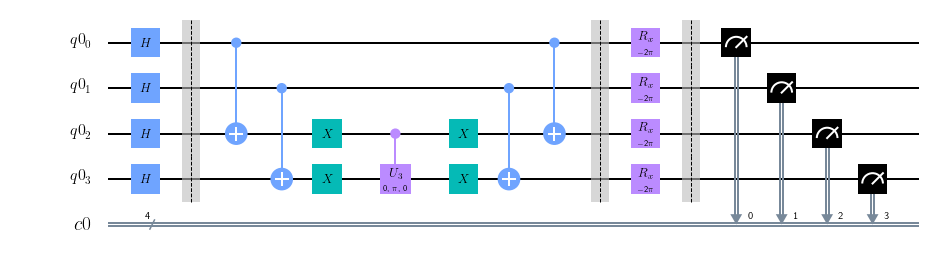

In [4]:
circuit = createCircuit_MaxKCut(K_CUTS,(np.pi,np.pi)*CIRCUIT_DEPTH,G,CIRCUIT_DEPTH,CIRCUIT_VERSION,usebarrier=True,
                                brute_force=BRUTE_FORCE)
circuit.draw()

In [5]:
(gamma_min,gamma_max),(beta_min,beta_max) = parameterBounds_MaxCut(G,decimals=WEIGHT_DECIMALS)
#gamma_min *= 2
#gamma_max *= 2
#beta_min *= 2
#beta_max *= 2


gamma_period = (gamma_max-gamma_min)*2
beta_period = beta_max-beta_min

# Use the weights to find the typical Fourier frequency. Then pick LANDSCAPE_RESOLUTION points
# within each sinusoid oscillation at this frequency.
gamma_typ_freq,beta_typ_freq = spatialFrequencies_MaxCut(G)

landscape_n_gamma = int(gamma_period*LANDSCAPE_RESOLUTION*np.ceil(gamma_typ_freq))
landscape_n_beta = int(beta_period*LANDSCAPE_RESOLUTION*np.ceil(beta_typ_freq))

print('landscape_n_gamma: %d' % landscape_n_gamma)
print('landscape_n_beta: %d' % landscape_n_beta)

gammas_landscape = np.linspace(gamma_min,gamma_max,landscape_n_gamma)
betas_landscape = np.linspace(beta_min,beta_max,landscape_n_beta)

E_landscape = np.zeros((landscape_n_beta,landscape_n_gamma))
E_landscape_bf = np.zeros((landscape_n_beta,landscape_n_gamma))
#E_landscape_2 = np.zeros((landscape_n_beta,landscape_n_gamma))
for i in range(landscape_n_beta):
    for j in range(landscape_n_gamma):
        beta = betas_landscape[i]
        gamma = gammas_landscape[j]
        circuit = createCircuit_MaxKCut(K_CUTS,np.array((gamma,beta)),G,CIRCUIT_DEPTH,CIRCUIT_VERSION,
                                       brute_force=False)
        circuit_bf = createCircuit_MaxKCut(K_CUTS,np.array((gamma,beta)),G,CIRCUIT_DEPTH,CIRCUIT_VERSION,
                                           brute_force=True)
        #circuit_2 = createCircuit_MaxCut(np.array((gamma,beta)),G,CIRCUIT_DEPTH,CIRCUIT_VERSION)
        [E_list,_,_] = sampleUntilPrecision_MaxKCut(K_CUTS,circuit,G,backend_sim,None,MIN_SAMPLES,
                                                             MAX_SAMPLES,SAMPLING_E_ATOL,SAMPLING_E_RTOL,
                                                             SAMPLING_DELTA_V_RTOL,SAMPLING_CONF_IDX)
        [E_list_bf,_,_] = sampleUntilPrecision_MaxKCut(K_CUTS,circuit_bf,G,backend_sim,None,MIN_SAMPLES,
                                                             MAX_SAMPLES,SAMPLING_E_ATOL,SAMPLING_E_RTOL,
                                                             SAMPLING_DELTA_V_RTOL,SAMPLING_CONF_IDX)
        #[E_list_2,_,_] = sampleUntilPrecision_MaxCut(circuit_2,G,backend_sim,None,MIN_SAMPLES,
        #                                                     MAX_SAMPLES,SAMPLING_E_ATOL,SAMPLING_E_RTOL,
        #                                                     SAMPLING_DELTA_V_RTOL,SAMPLING_CONF_IDX)
        E_landscape[i,j] = -E_list[-1]
        E_landscape_bf[i,j] = -E_list_bf[-1]
        #E_landscape_2[i,j] = -E_list_2[-1]
        print('%.2f%%' % ((i*landscape_n_gamma+j)*100/(landscape_n_gamma*landscape_n_beta)),end='\r')
        

landscape_n_gamma: 100
landscape_n_beta: 25


Prepare the initial points from which we will do the optimizations.

In [6]:
def getval(x,history_ref,backend,k_cuts,depth,version,n_shots):
    circuit = createCircuit_MaxKCut(k_cuts,x,G,depth,version,brute_force=BRUTE_FORCE)
    experiment = execute(circuit, backend, noise_model=None, shots=n_shots)
    E_list,v_list = measurementStatistics_MaxKCut(k_cuts,experiment.result().results,G)

    history_ref['gammas'].append(x[0])
    history_ref['betas'].append(x[1])
    history_ref['expectations'].append(E_list)
    history_ref['variances'].append(v_list)
    history_ref['n_shots'].append(n_shots)
        
    return -E_list[-1]

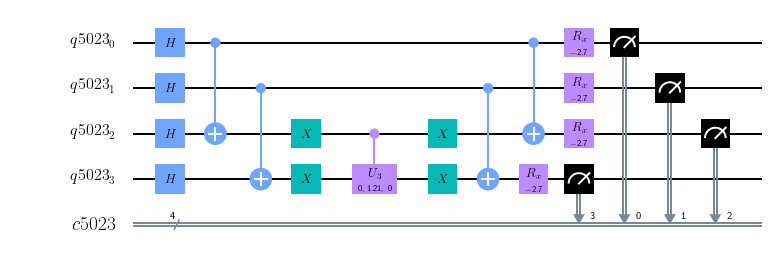

In [7]:
opt_history = {
    'gammas': [],
    'betas': [],
    'expectations': [],
    'variances': [],
    'n_shots': [],
}
opt.minimize(getval, x0=(1.2,1.2), method='COBYLA',
             args=(opt_history,backend_sim,K_CUTS,CIRCUIT_DEPTH,CIRCUIT_VERSION,MAX_SAMPLES),
             options={'rhobeg': 1e-1, 'disp': True, 'maxiter': 10000, 'tol': 1e-3})

best_params = (opt_history['gammas'][-1],opt_history['betas'][-1])
optimal_circuit = createCircuit_MaxKCut(K_CUTS,best_params,G,1,CIRCUIT_VERSION,brute_force=BRUTE_FORCE)
optimal_experiment = execute(optimal_circuit, backend_sim, shots=MAX_SAMPLES)
optimal_circuit.draw()

Let us verify that the optimizations seem to work correctly.

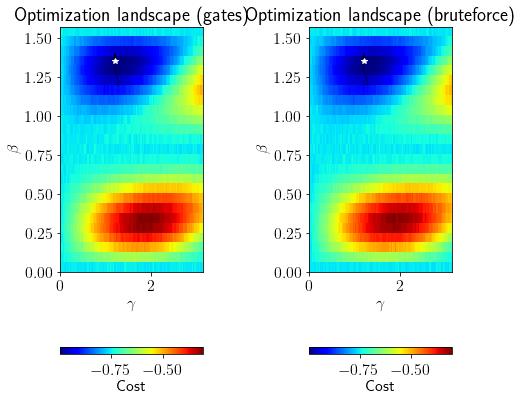

In [8]:
pl.figure(figsize=(10,6))
pl.subplot(1,3,1)
pl.imshow(np.array(E_landscape).reshape(landscape_n_beta,landscape_n_gamma),
          origin='lower',interpolation='nearest',cmap=cm.jet,aspect='auto',
          extent=[gammas_landscape[0],gammas_landscape[-1],betas_landscape[0],betas_landscape[-1]])


gammas = list(opt_history['gammas'])
betas = list(opt_history['betas'])
for it in range(len(gammas)):
    gammas[it],betas[it] = wrapParameters_MaxCut(gammas[it],betas[it],
                                                 (gamma_min,gamma_max),
                                                 (beta_min,beta_max))
pl.plot(gammas,betas,'k-',linewidth=0.5)
pl.plot(gammas[-1],betas[-1],'w*')
cbar = pl.colorbar(orientation="horizontal", pad=0.2)
cbar.set_label('Cost')
#pl.clim(-1,0)
pl.xlabel(r'$\gamma$')
pl.ylabel(r'$\beta$')
pl.title('Optimization landscape (gates)')

pl.subplot(1,3,2)
pl.imshow(np.array(E_landscape_bf).reshape(landscape_n_beta,landscape_n_gamma),
          origin='lower',interpolation='nearest',cmap=cm.jet,aspect='auto',
          extent=[gammas_landscape[0],gammas_landscape[-1],betas_landscape[0],betas_landscape[-1]])
cbar = pl.colorbar(orientation="horizontal", pad=0.2)
cbar.set_label('Cost')
#pl.clim(-1,0)
pl.xlabel(r'$\gamma$')
pl.ylabel(r'$\beta$')
pl.title('Optimization landscape (bruteforce)')

pl.plot(gammas,betas,'k-',linewidth=0.5)
pl.plot(gammas[-1],betas[-1],'w*')
pl.tight_layout()

#pl.subplot(1,3,3)
#pl.imshow(np.array(E_landscape_2).reshape(landscape_n_beta,landscape_n_gamma),
#          origin='lower',interpolation='nearest',cmap=cm.jet,aspect='auto',
#          extent=[gammas_landscape[0],gammas_landscape[-1],betas_landscape[0],betas_landscape[-1]])
#cbar = pl.colorbar(orientation="horizontal", pad=0.2)
#cbar.set_label('Cost')
#pl.xlabel(r'$\gamma$')

#pl.ylabel(r'$\beta$')
#pl.title('Optimization landscape (2)')

In [9]:
# Optimal

counts_binary = optimal_experiment.result().get_counts()

label_counts = dict()
cost_counts = dict()
num_V = G.number_of_nodes()

for binstring in counts_binary.keys():
    labels = binstringToLabels_MaxKCut(K_CUTS,num_V,binstring)
    cost = cost_MaxKCut(K_CUTS,labels,G)
        
    new_key = '%s/%.2f' % (labels,cost)
    label_counts[new_key] = counts_binary[binstring]
    if cost not in cost_counts:
        cost_counts[cost] = 0
    cost_counts[cost] += counts_binary[binstring]
    
# Random
random_cost_counts = dict()

k_bits = kBits_MaxKCut(K_CUTS)
num_V = G.number_of_nodes()
tot_bits = num_V*k_bits

for i in range(K_CUTS**num_V):
    binstring = "{0:b}".format(i).zfill(tot_bits)
    labels = binstringToLabels_MaxKCut(K_CUTS,num_V,binstring)
    cost = cost_MaxKCut(K_CUTS,labels,G)
    if cost not in random_cost_counts.keys():
        random_cost_counts[cost] = 0
    random_cost_counts[cost] += 1

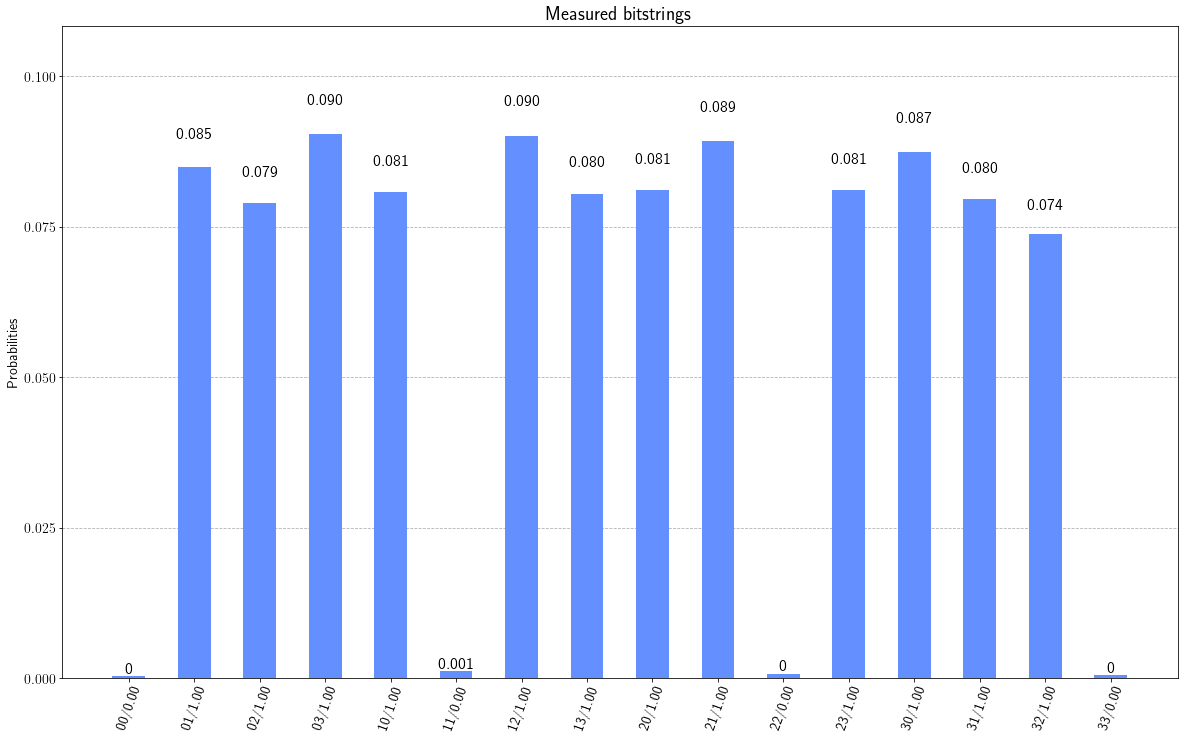

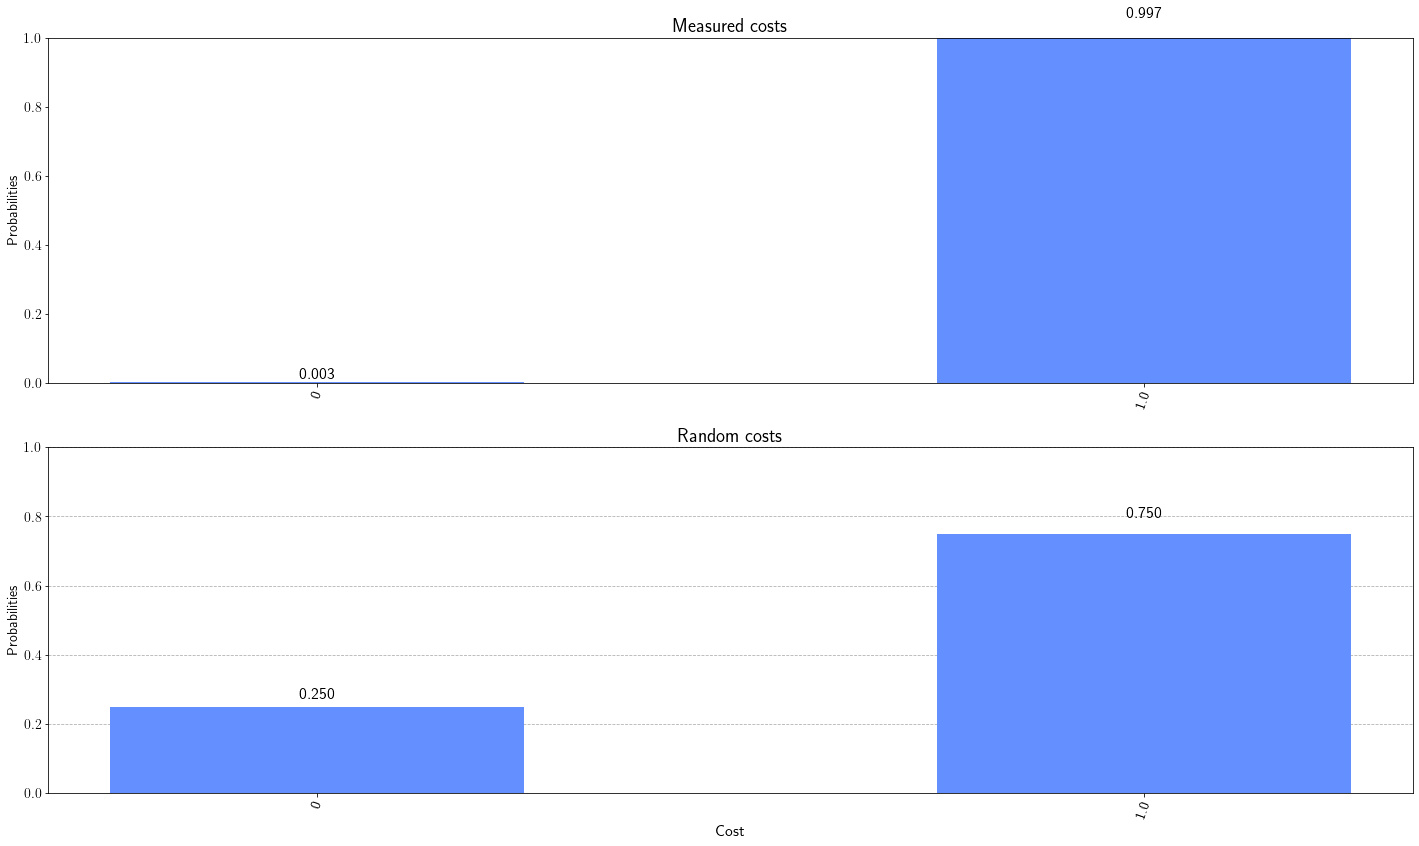

In [10]:
fig, ax = pl.subplots(figsize=(20,12))
plot_histogram(label_counts,title='Measured bitstrings',ax=ax)

fig,axs = pl.subplots(2,1,figsize=(20,12))
plot_histogram(cost_counts,ax=axs[0])
axs[0].set_title('Measured costs')
axs[0].set_ylim(0,1)
plot_histogram(random_cost_counts,ax=axs[1])
axs[1].set_title('Random costs')
axs[1].set_xlabel('Cost')
axs[1].set_ylim(0,1)

pl.tight_layout()

In [11]:
c4=QuantumCircuit(4)
c4.cx(0,2)
c4.cx(1,3)
c4.x(2)
c4.x(3)
c4.barrier()
c4.cz(2,3)
c4.barrier()
c4.x(2)
c4.x(3)
c4.cx(0,2)
c4.cx(1,3)
c4.draw()

usim = Aer.get_backend('unitary_simulator')
result = execute(c4, usim).result()
unitary = result.get_unitary(c4)
print("Circuit unitary:\n", np.real(unitary))

Circuit unitary:
 [[-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0